# Approximate a simulated non-linear function

# Task
- Use fully connected network to approximate a simulated non-linear function

## Data Exploration

In [1]:
file_name = '/src/data/function_approximation/xy_data.csv'

import pandas as pd
import numpy as np
df = pd.read_csv(file_name, header=None)
print(df.shape)

(3, 2000)


In [2]:
np_vector = df.values.transpose()
print(type(np_vector))
print(np_vector.shape)
print(np_vector[:5])

<class 'numpy.ndarray'>
(2000, 3)
[[-0.058929   0.06417    0.33     ]
 [ 0.16602   -0.0084448  0.33     ]
 [ 0.50408    0.098609   0.5      ]
 [-0.63563    0.97851    0.       ]
 [-0.63486    0.92308    0.       ]]


min:-0.999560, max:0.997750, median:-0.036787, mean:-0.033911, std:0.581712, size:2000


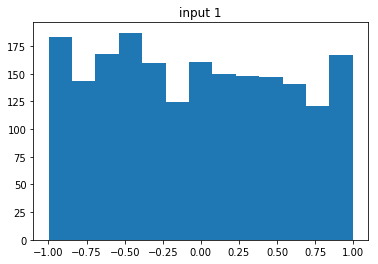

min:-0.999790, max:0.999340, median:-0.008641, mean:-0.007416, std:0.577141, size:2000


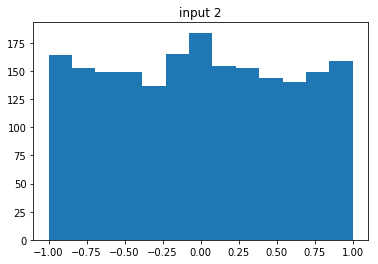

min:-0.500000, max:0.830000, median:0.000000, mean:0.034030, std:0.265202, size:2000


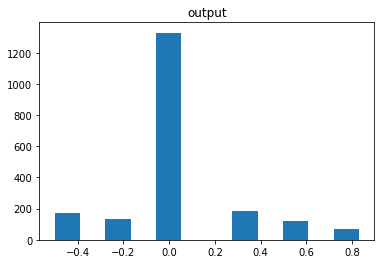

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

x = np_vector[:, 0]
y = np_vector[:, 1]
tk = np_vector[:,2]

def explore_vector(vector, title=None):
    assert type(vector) is np.ndarray
    assert vector.ndim == 1
    print('min:%f, max:%f, median:%f, mean:%f, std:%f, size:%d' 
          % (np.min(vector), np.max(vector), np.median(vector), np.mean(vector), np.std(vector), vector.size))
    plt.title(title)
    plt.hist(vector, bins='auto')
    plt.show()

explore_vector(x, "input 1")
explore_vector(y, "input 2")
explore_vector(tk, "output")

## Data Preparation

In [4]:
# Let's shuffle it
np.random.shuffle(np_vector)
print(np_vector[:5])

[[ 0.58309  -0.88586   0.      ]
 [-0.86835  -0.98764   0.      ]
 [-0.21888   0.043961  0.83    ]
 [ 0.42978   0.90952   0.      ]
 [-0.25649   0.98074   0.      ]]


In [5]:
# separate input and output
input_vector = np_vector[:, :2]
print('input shape:' + str(input_vector.shape))
print(input_vector[:5])

output_vecotr = np_vector[:, 2]
print('output shape:' + str(output_vecotr.shape))
print(output_vecotr[:5])

input shape:(2000, 2)
[[ 0.58309  -0.88586 ]
 [-0.86835  -0.98764 ]
 [-0.21888   0.043961]
 [ 0.42978   0.90952 ]
 [-0.25649   0.98074 ]]
output shape:(2000,)
[0.   0.   0.83 0.   0.  ]


In [6]:
pct_training = 0.9
pct_validation = 0.1

# separate training and test data
total_size = input_vector.shape[0]
training_size = int(total_size * pct_training)
test_size = total_size - training_size
val_size = int(training_size * pct_validation)

print('Total Size: %d, Train Size: %d, Validation Size: %d, Test Size: %d'
      % (total_size, training_size - val_size, val_size, test_size))

# slice data
train_in = input_vector[:training_size]
train_out = output_vecotr[:training_size]

test_in = input_vector[training_size:]
test_out = output_vecotr[training_size:]


val_in = train_in[:val_size]
val_out = train_out[:val_size]

train_in = train_in[val_size:]
train_out = train_out[val_size:]

print('train_in shape:' + str(train_in.shape))


Total Size: 2000, Train Size: 1620, Validation Size: 180, Test Size: 200
train_in shape:(1620, 2)


# Model Construction

In [7]:
from keras import models
from keras import layers

# construct model
model = models.Sequential()
model.add(layers.Dense(32, activation='relu', input_shape=(2,)))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(8, activation='relu'))
model.add(layers.Dense(1))

model.summary()

# custom metrics
import keras.backend as K

def max_diff(y_true, y_pred):
    return K.max(K.abs(y_pred-y_true))

def min_diff(y_true, y_pred):
    return K.min(K.abs(y_pred-y_true))

# compile model with optimizer, loss function
model.compile(optimizer='rmsprop',
              loss='mean_squared_error',
              metrics=[max_diff, min_diff])

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                96        
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_3 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_4 (Dense)              (None, 32)                1056      
_________________________________________________________________
dense_5 (Dense)              (None, 16)                528       
_________________________________________________________________
dense_6 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_7 (Dense)              (None, 16)                272       
__________

In [8]:
history = model.fit(train_in,
                    train_out,
                    epochs=2000,
                    verbose=0,
                    batch_size=32,
                    validation_data=(val_in, val_out))

In [9]:
# check out history object
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_max_diff', 'val_min_diff', 'loss', 'max_diff', 'min_diff'])

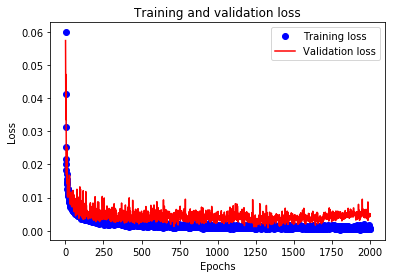

In [10]:
%matplotlib inline
import matplotlib.pyplot as plt

loss = history.history['loss']
val_loss = history.history['val_loss']

max_diff = history.history['max_diff']
val_max_diff = history.history['val_max_diff']

min_diff = history.history['min_diff']
val_min_diff = history.history['val_min_diff']

epochs = range(1, len(loss) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss, 'bo', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

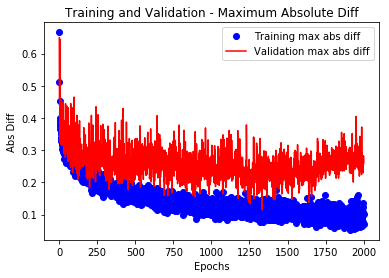

In [11]:
plt.clf()   # clear figure
plt.plot(epochs, max_diff, 'bo', label='Training max abs diff')
plt.plot(epochs, val_max_diff, 'r', label='Validation max abs diff')
plt.title('Training and Validation - Maximum Absolute Diff')
plt.xlabel('Epochs')
plt.ylabel('Abs Diff')
plt.legend()

plt.show()

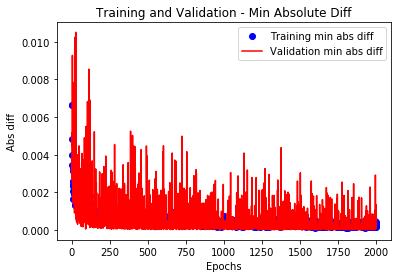

In [12]:
plt.clf()   # clear figure
plt.plot(epochs, min_diff, 'bo', label='Training min abs diff')
plt.plot(epochs, val_min_diff, 'r', label='Validation min abs diff')
plt.title('Training and Validation - Min Absolute Diff')
plt.xlabel('Epochs')
plt.ylabel('Abs diff')
plt.legend()

plt.show()

## Model Evaluation

In [13]:
# evaulate model with test data
results = model.evaluate(test_in, test_out)
results

200/200 [==============================] - 0s 29us/step


[0.003734155984748213, 0.23169895708560945, 5.0840675830841066e-05]

In [14]:
pre_test_out = model.predict(test_in)
pre_test_out = pre_test_out.flatten()

min:-0.508127, max:0.831291, median:-0.000544, mean:0.016464, std:0.227684, size:200


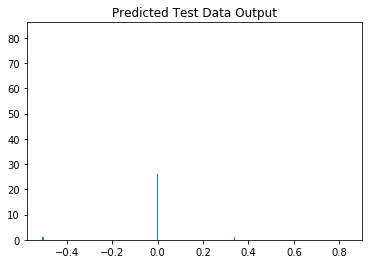

In [15]:
explore_vector(pre_test_out, 'Predicted Test Data Output')

min:-0.500000, max:0.830000, median:0.000000, mean:0.017700, std:0.233940, size:200


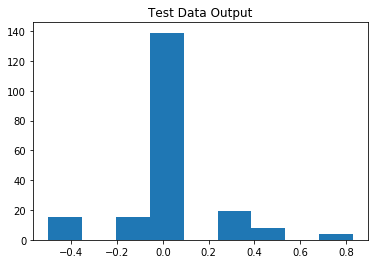

In [16]:
explore_vector(test_out, 'Test Data Output')

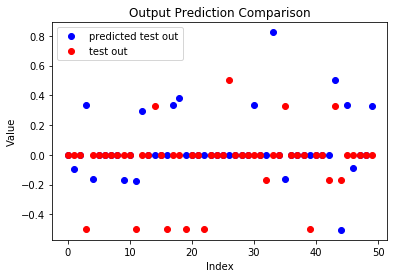

In [22]:
plt.clf()   # clear figure
NUM_PLOT = 50
START = 100
plt.plot(pre_test_out[START: START + NUM_PLOT], 'bo', label='predicted test out')
plt.plot(test_out[:NUM_PLOT], 'ro', label='test out')
plt.title('Output Prediction Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
#plt.rcParams['figure.figsize'] = [20, 20]
#plt.figure(figsize=(20, 20), dpi= 20)
plt.show()

min:0.000010, max:0.503642, median:0.000773, mean:0.011717, std:0.059974, size:200


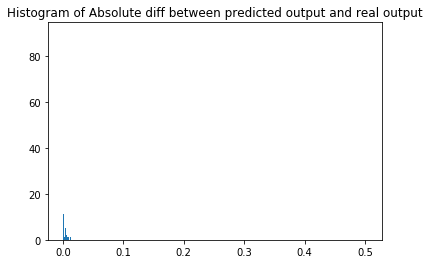

In [23]:
abs_diff_test_out = abs(pre_test_out - test_out)
plt.clf()   # clear figure
explore_vector(abs_diff_test_out, 'Histogram of Absolute diff between predicted output and real output')

Text(0, 0.5, 'Abs Diff')

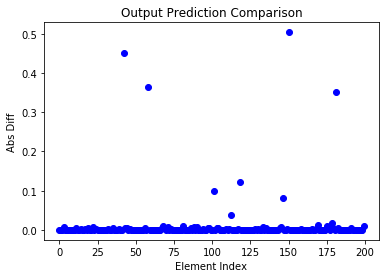

In [19]:
plt.clf()   # clear figure
plt.plot(abs_diff_test_out, 'bo', label='abs diff test out')
plt.title('Output Prediction Comparison')
plt.xlabel('Element Index')
plt.ylabel('Abs Diff')


min:0.121060, max:0.503642, median:0.363033, mean:0.358150, std:0.131119, size:5


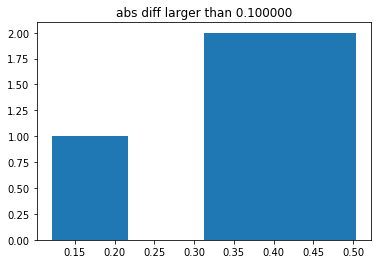

In [26]:
thresh_hold = 0.1
bin_array = np.asarray([a_diff for a_diff in abs_diff_test_out if a_diff > thresh_hold])
explore_vector(bin_array, 'abs diff larger than %f' % thresh_hold)

min:0.010148, max:0.503642, median:0.097974, mean:0.186197, std:0.181956, size:11


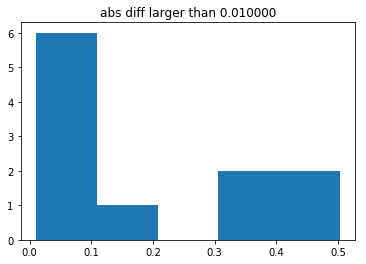

In [27]:
thresh_hold = 0.01
bin_array = np.asarray([a_diff for a_diff in abs_diff_test_out if a_diff > thresh_hold])
explore_vector(bin_array, 'abs diff larger than %f' % thresh_hold)

## Summary
- From the loss plot, the overfitting starts at 1000 epochs.
- The loss of training data is in 3 decmial digit.
- Out of 200 test data, only 5 predicted output is more than 0.1. In other word, 2.5% probability the predicted error is more than 0.1
- Out of 200 test data, only 11 predicted output is more than 0.01. In other word, 5% probability the predicted error is more than 0.01